# 1. Title, Name and References

#### Classification Analysis using feature selection and various classification models to improve accuracy score

#### Introduction
This project objective is to perfom a classification analysis over a sampled dataset from a baking instute in Portugal in order to understand what are the variables that produce the most impact over a client's decision to subscribe to a term deposit offered by the bank, and predict with a good level of accuracy what would be the outcome given a hypothetical scenario. 
The steps used for this analysis were first the implementation of three different feature selection models to identify what features should be used for the analyses, second the execution of a pipeline model containing six classifiers in order to find which would present the best accuracy score. And finaly exercise a out of the original sample prediction example.

#### Team member
1. Ngoc Chau Tran - 300307368
2. Leozítor Floro de Souza - 300334919
3. Carolina Henrique de Melo Louback - 300306289

#### References
- Class notes
- Samuel Otim class notes from CSIS 4260 coursed in fall 2020

# 2. Library import and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from numpy import mean
from sklearn import metrics
from datetime import datetime as dt
from xgboost import XGBClassifier
from sklearn import datasets, linear_model
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, log_loss, classification_report, roc_curve, roc_auc_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

%matplotlib inline

# 3. Data Analysis, Preparation and Wrangling

In [2]:
df2 = pd.read_csv('bank-sampled.csv') # full dataset
df = pd.read_csv('bank-sampled-9K.csv') # 20% dataset

In [3]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,no
1,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,no
2,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,no
3,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,no
4,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9037,26,admin.,single,tertiary,no,689,no,no,cellular,25,mar,78,1,-1,0,unknown,no
9038,47,management,married,tertiary,no,1890,no,no,cellular,8,jul,161,1,-1,0,unknown,no
9039,32,blue-collar,single,secondary,no,217,yes,no,cellular,15,may,692,3,-1,0,unknown,yes
9040,52,admin.,divorced,secondary,no,0,yes,no,unknown,26,may,206,1,-1,0,unknown,no


In [4]:
df2

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [5]:
# dropping duration as suggested by the documentation
df.drop('duration', axis=1, inplace=True)

#Convert the two-column time to a column containing the number of days till the last day of campaing
last_date = "18 Nov, 2010" # assume the analysis date was nov 18th 2010.
dt_1 = dt.strptime(last_date, "%d %b, %Y") #change it to datetime

#Convert month first letter to upper case
df['month'] = df['month'].apply(lambda x: x.capitalize())
df['date'] = df['day'].astype(str) + " " + df['month'] + ", 2010"

#Calculate duration between two dates
df['last_contact'] = df['date'].apply(lambda x: (dt_1 - dt.strptime(x, "%d %b, %Y")).days)

#drop unacessary columns
df.drop(columns={'day', 'date', 'month'}, axis=1, inplace=True)

In [6]:
df

,age,job,marital,education,default,balance,housing,loan,contact,campaign,pdays,previous,poutcome,y,last_contact
0,40,blue-collar,married,secondary,no,580,yes,no,unknown,1,-1,0,unknown,no,186
1,47,services,single,secondary,no,3644,no,no,unknown,2,-1,0,unknown,no,162
2,25,student,single,tertiary,no,538,yes,no,cellular,1,-1,0,unknown,no,212
3,42,management,married,tertiary,no,1773,no,no,cellular,1,336,1,failure,no,223
4,56,management,married,tertiary,no,217,no,yes,cellular,2,-1,0,unknown,no,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9037,26,admin.,single,tertiary,no,689,no,no,cellular,1,-1,0,unknown,no,238
9038,47,management,married,tertiary,no,1890,no,no,cellular,1,-1,0,unknown,no,133
9039,32,blue-collar,single,secondary,no,217,yes,no,cellular,3,-1,0,unknown,yes,187
9040,52,admin.,divorced,secondary,no,0,yes,no,unknown,1,-1,0,unknown,no,176


In [7]:
df.shape

(9042, 15)

In [8]:
# Display the summary statistics of the data
df.describe()

,age,balance,campaign,pdays,previous,last_contact
count,9042.000000,9042.000000,9042.000000,9042.000000,9042.000000,9042.000000
mean,40.958195,1367.082061,2.756691,40.273391,0.580624,151.159699
std,10.621398,3130.311959,3.008022,100.223320,2.012452,74.298372
min,18.000000,-2712.000000,1.000000,-1.000000,0.000000,-43.000000
25%,33.000000,79.000000,1.000000,-1.000000,0.000000,105.000000
50%,39.000000,453.500000,2.000000,-1.000000,0.000000,167.000000
75%,48.000000,1414.750000,3.000000,-1.000000,0.000000,193.000000
max,93.000000,98417.000000,55.000000,842.000000,58.000000,315.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9042 entries, 0 to 9041
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           9042 non-null   int64 
 1   job           9042 non-null   object
 2   marital       9042 non-null   object
 3   education     9042 non-null   object
 4   default       9042 non-null   object
 5   balance       9042 non-null   int64 
 6   housing       9042 non-null   object
 7   loan          9042 non-null   object
 8   contact       9042 non-null   object
 9   campaign      9042 non-null   int64 
 10  pdays         9042 non-null   int64 
 11  previous      9042 non-null   int64 
 12  poutcome      9042 non-null   object
 13  y             9042 non-null   object
 14  last_contact  9042 non-null   int64 
dtypes: int64(6), object(9)
memory usage: 1.0+ MB


In [10]:
df[['job', 'marital', 'education', 'contact', 'poutcome']]

,job,marital,education,contact,poutcome
0,blue-collar,married,secondary,unknown,unknown
1,services,single,secondary,unknown,unknown
2,student,single,tertiary,cellular,unknown
3,management,married,tertiary,cellular,failure
4,management,married,tertiary,cellular,unknown
...,...,...,...,...,...
9037,admin.,single,tertiary,cellular,unknown
9038,management,married,tertiary,cellular,unknown
9039,blue-collar,single,secondary,cellular,unknown
9040,admin.,divorced,secondary,unknown,unknown


In [11]:
# Number of unique values in each column
df.nunique()

age               71
job               12
marital            3
education          4
default            2
balance         3474
housing            2
loan               2
contact            3
campaign          36
pdays            373
previous          32
poutcome           4
y                  2
last_contact     284
dtype: int64

In [12]:
# Verifying if Null values exist
df.isnull().sum()

age             0
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
campaign        0
pdays           0
previous        0
poutcome        0
y               0
last_contact    0
dtype: int64

<AxesSubplot:title={'center':'JOB'}>

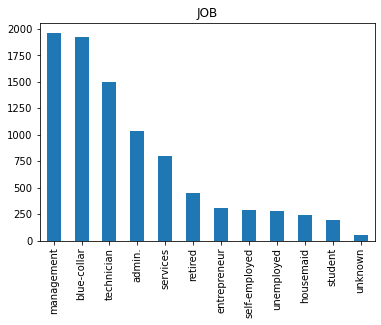

In [13]:
#Job
df['job'].value_counts().plot(kind='bar', title='JOB')

<AxesSubplot:title={'center':'Marital'}>

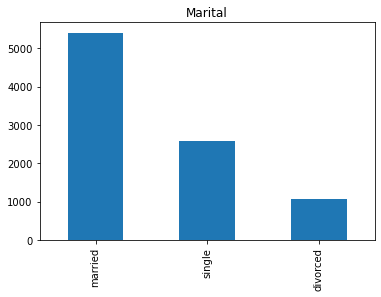

In [14]:
#Marital
df['marital'].value_counts().plot(kind='bar', title='Marital')

<AxesSubplot:title={'center':'Education'}>

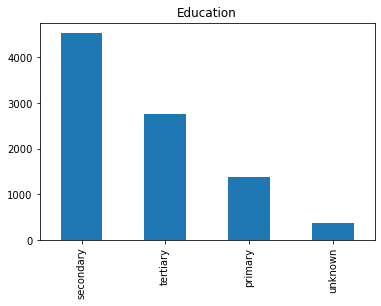

In [15]:
#education
df['education'].value_counts().plot(kind='bar', title='Education')

<AxesSubplot:title={'center':'Contact'}>

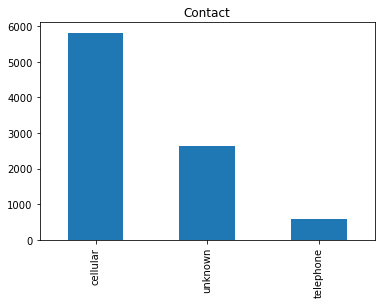

In [16]:
#contact
df['contact'].value_counts().plot(kind='bar', title='Contact')

<AxesSubplot:title={'center':'pOutcome'}>

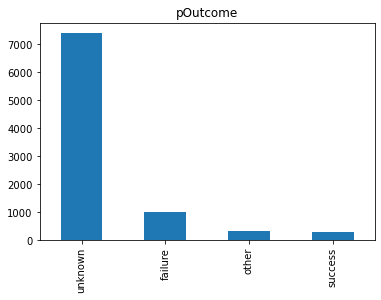

In [17]:
#poutcome
df['poutcome'].value_counts().plot(kind='bar', title='pOutcome')

We started our analysis by choosing to drop the first dummy of each varibles when creating them, but after a discussion in class we decided to test the fetaure selection with and with out dropping the first variable.


In [18]:
#Get dummy variables from catgeorical variables
job = pd.get_dummies(df['job'],prefix='job',drop_first=True)
marital = pd.get_dummies(df['marital'],prefix='marital',drop_first=True)
education = pd.get_dummies(df['education'],prefix='education',drop_first=True)
default = pd.get_dummies(df['default'],prefix='default',drop_first=True)
housing = pd.get_dummies(df['housing'],prefix='housing',drop_first=True)
loan = pd.get_dummies(df['loan'],prefix='loan',drop_first=True)
contact = pd.get_dummies(df['contact'],prefix='contact',drop_first=True)
poutcome = pd.get_dummies(df['poutcome'],prefix='poutcome',drop_first=True)
y = pd.get_dummies(df['y'],prefix='y',drop_first=True)

In [19]:
#Add job dummies to dataframe and drop original job column
df = df.join(job)
df.drop('job', axis=1, inplace=True)
df.head()

,age,marital,education,default,balance,housing,loan,contact,campaign,pdays,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,40,married,secondary,no,580,yes,no,unknown,1,-1,...,0,0,0,0,0,0,0,0,0,0
1,47,single,secondary,no,3644,no,no,unknown,2,-1,...,0,0,0,0,0,1,0,0,0,0
2,25,single,tertiary,no,538,yes,no,cellular,1,-1,...,0,0,0,0,0,0,1,0,0,0
3,42,married,tertiary,no,1773,no,no,cellular,1,336,...,0,0,1,0,0,0,0,0,0,0
4,56,married,tertiary,no,217,no,yes,cellular,2,-1,...,0,0,1,0,0,0,0,0,0,0


In [20]:
#Add marital dummies to dataframe and drop original column
df = df.join(marital)
df.drop('marital', axis=1, inplace=True)
df.head()

,age,education,default,balance,housing,loan,contact,campaign,pdays,previous,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single
0,40,secondary,no,580,yes,no,unknown,1,-1,0,...,0,0,0,0,0,0,0,0,1,0
1,47,secondary,no,3644,no,no,unknown,2,-1,0,...,0,0,0,1,0,0,0,0,0,1
2,25,tertiary,no,538,yes,no,cellular,1,-1,0,...,0,0,0,0,1,0,0,0,0,1
3,42,tertiary,no,1773,no,no,cellular,1,336,1,...,1,0,0,0,0,0,0,0,1,0
4,56,tertiary,no,217,no,yes,cellular,2,-1,0,...,1,0,0,0,0,0,0,0,1,0


In [21]:
#Add education dummies to dataframe and drop original column
df = df.join(education)
df.drop('education', axis=1, inplace=True)
df.head()

,age,default,balance,housing,loan,contact,campaign,pdays,previous,poutcome,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,40,no,580,yes,no,unknown,1,-1,0,unknown,...,0,0,0,0,0,1,0,1,0,0
1,47,no,3644,no,no,unknown,2,-1,0,unknown,...,1,0,0,0,0,0,1,1,0,0
2,25,no,538,yes,no,cellular,1,-1,0,unknown,...,0,1,0,0,0,0,1,0,1,0
3,42,no,1773,no,no,cellular,1,336,1,failure,...,0,0,0,0,0,1,0,0,1,0
4,56,no,217,no,yes,cellular,2,-1,0,unknown,...,0,0,0,0,0,1,0,0,1,0


In [22]:
#Add default dummies to dataframe and drop original column
df = df.join(default)
df.drop('default', axis=1, inplace=True)
df.head()

,age,balance,housing,loan,contact,campaign,pdays,previous,poutcome,y,...,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes
0,40,580,yes,no,unknown,1,-1,0,unknown,no,...,0,0,0,0,1,0,1,0,0,0
1,47,3644,no,no,unknown,2,-1,0,unknown,no,...,0,0,0,0,0,1,1,0,0,0
2,25,538,yes,no,cellular,1,-1,0,unknown,no,...,1,0,0,0,0,1,0,1,0,0
3,42,1773,no,no,cellular,1,336,1,failure,no,...,0,0,0,0,1,0,0,1,0,0
4,56,217,no,yes,cellular,2,-1,0,unknown,no,...,0,0,0,0,1,0,0,1,0,0


In [23]:
#Add housing dummies to dataframe and drop original column
df = df.join(housing)
df.drop('housing', axis=1, inplace=True)
df.head()

,age,balance,loan,contact,campaign,pdays,previous,poutcome,y,last_contact,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes
0,40,580,no,unknown,1,-1,0,unknown,no,186,...,0,0,0,1,0,1,0,0,0,1
1,47,3644,no,unknown,2,-1,0,unknown,no,162,...,0,0,0,0,1,1,0,0,0,0
2,25,538,no,cellular,1,-1,0,unknown,no,212,...,0,0,0,0,1,0,1,0,0,1
3,42,1773,no,cellular,1,336,1,failure,no,223,...,0,0,0,1,0,0,1,0,0,0
4,56,217,yes,cellular,2,-1,0,unknown,no,120,...,0,0,0,1,0,0,1,0,0,0


In [24]:
#Add loan dummies to dataframe and drop original column
df = df.join(loan)
df.drop('loan', axis=1, inplace=True)
df.head()

,age,balance,contact,campaign,pdays,previous,poutcome,y,last_contact,job_blue-collar,...,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes
0,40,580,unknown,1,-1,0,unknown,no,186,1,...,0,0,1,0,1,0,0,0,1,0
1,47,3644,unknown,2,-1,0,unknown,no,162,0,...,0,0,0,1,1,0,0,0,0,0
2,25,538,cellular,1,-1,0,unknown,no,212,0,...,0,0,0,1,0,1,0,0,1,0
3,42,1773,cellular,1,336,1,failure,no,223,0,...,0,0,1,0,0,1,0,0,0,0
4,56,217,cellular,2,-1,0,unknown,no,120,0,...,0,0,1,0,0,1,0,0,0,1


In [25]:
#Add contact dummies to dataframe and drop original column
df = df.join(contact)
df.drop('contact', axis=1, inplace=True)
df.head()

,age,balance,campaign,pdays,previous,poutcome,y,last_contact,job_blue-collar,job_entrepreneur,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown
0,40,580,1,-1,0,unknown,no,186,1,0,...,1,0,1,0,0,0,1,0,0,1
1,47,3644,2,-1,0,unknown,no,162,0,0,...,0,1,1,0,0,0,0,0,0,1
2,25,538,1,-1,0,unknown,no,212,0,0,...,0,1,0,1,0,0,1,0,0,0
3,42,1773,1,336,1,failure,no,223,0,0,...,1,0,0,1,0,0,0,0,0,0
4,56,217,2,-1,0,unknown,no,120,0,0,...,1,0,0,1,0,0,0,1,0,0


In [26]:
#Add poutcome dummies to dataframe and drop original column
df = df.join(poutcome)
df.drop('poutcome', axis=1, inplace=True)
df.head()

,age,balance,campaign,pdays,previous,y,last_contact,job_blue-collar,job_entrepreneur,job_housemaid,...,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,40,580,1,-1,0,no,186,1,0,0,...,0,0,0,1,0,0,1,0,0,1
1,47,3644,2,-1,0,no,162,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,25,538,1,-1,0,no,212,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,42,1773,1,336,1,no,223,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,56,217,2,-1,0,no,120,0,0,0,...,1,0,0,0,1,0,0,0,0,1


In [27]:
#Add y dummies to dataframe and drop original column
df = df.join(y)
df.drop('y', axis=1, inplace=True)
df.head()

,age,balance,campaign,pdays,previous,last_contact,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,40,580,1,-1,0,186,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,47,3644,2,-1,0,162,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,25,538,1,-1,0,212,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,42,1773,1,336,1,223,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,56,217,2,-1,0,120,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [28]:
#replacing any appearance of hypen ‘-‘
df=df.rename(columns=lambda x:x.replace('-','_'))

In [29]:
df.columns

Index(['age', 'balance', 'campaign', 'pdays', 'previous', 'last_contact',
       'job_blue_collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self_employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown', 'y_yes'],
      dtype='object')

# 4 Feature Selection and Scaling

Perform feature selection from the dataset. Use the following feature selection methods and choose
the feature selection method that has the lowest number of features. If there is a tie, you should select
the first method that has the lowest number of features.

In [30]:
#Define the X (features) and Y (outcome variable)
X = df.drop(['y_yes'], axis=1)
y = df['y_yes']
X.shape

(9042, 30)

There are currently 30 features and we need to find out how many of those are statistically significant to keep for our analysis.

### 4.1 Logistic Regression

In [31]:
#obtain the variables with higher coefficients
logisticRegression_method = SelectFromModel(estimator=LogisticRegression(max_iter=5000)).fit(X,y)
logisticRegression_method.estimator_.coef_

array([[-4.90078888e-03,  1.92572337e-05, -1.28615561e-01,
        -2.96470335e-04,  4.91087596e-02,  1.05358921e-03,
        -3.50867361e-01, -8.17873701e-02, -5.43502025e-02,
         4.20600404e-02,  2.96129142e-01, -4.58941260e-02,
        -1.58423690e-01,  1.03469462e-01, -6.20079785e-02,
         8.34722747e-03,  7.88458564e-03, -3.67831851e-01,
         3.96596469e-02, -3.44218773e-01,  1.11651864e-01,
         7.08991356e-02, -1.81597526e-02, -9.48918064e-01,
        -3.50056743e-01,  1.21606050e-02, -6.33711135e-01,
        -5.69239381e-02,  6.05646977e-01, -5.57606469e-01]])

In [32]:
#Obtain threshold value as the parameter to know which features should be removed
#according to this method
logisticRegression_method.threshold_

0.18375535220145733

In [33]:
#Run get_support() to see which are TRUE for significant features
logisticRegression_method.get_support(indices=True)

array([ 6, 10, 17, 19, 23, 24, 26, 28, 29])

In [34]:
#Apply transform() to get the subset of features to be used
X_logisticR = logisticRegression_method.transform(X)
X_logisticR.shape

(9042, 9)

Out of 30 features, the logistic regression features selecting method finds 11 features to be statistically significant for the analysis.
'job_blue-collar'
'job_retired'
'marital_married'
'housing_yes'
'loan_yes'
'contact_unknown'
'poutcome_success'
'poutcome_unknown'

In [35]:
#create a dataframe to save selected features by this method
X_logisticR_df = X.iloc[:,[6, 7, 8, 10, 13, 17, 23, 24, 26, 28, 29]].copy()
X_logisticR_df.head()

,job_blue_collar,job_entrepreneur,job_housemaid,job_retired,job_student,marital_married,housing_yes,loan_yes,contact_unknown,poutcome_success,poutcome_unknown
0,1,0,0,0,0,1,1,0,1,0,1
1,0,0,0,0,0,0,0,0,1,0,1
2,0,0,0,0,1,0,1,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,1


### 4.2 Linear SVM

In [36]:
#The generalized  linear model is usually used for feature explanation and observation
svm_method = sm.GLM(y, X, family=sm.families.Binomial())
report=svm_method.fit(fit_intercept=True)
print(report.summary2())

                 Results: Generalized linear model
Model:               GLM               AIC:             5790.2952  
Link Function:       logit             BIC:             -76365.7414
Dependent Variable:  y_yes             Log-Likelihood:  -2865.1    
Date:                2021-03-19 14:36  LL-Null:         -3329.6    
No. Observations:    9042              Deviance:        5730.3     
Df Model:            29                Pearson chi2:    9.50e+03   
Df Residuals:        9012              Scale:           1.0000     
Method:              IRLS                                          
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
age                 -0.0130   0.0034 -3.8353 0.0001 -0.0197 -0.0064
balance              0.0000   0.0000  2.7222 0.0065  0.0000  0.0000
campaign            -0.1234   0.0193 -6.3884 0.0000 -0.1613 -0.08

In [37]:
#use regularization hyperparameter value 0.001
report.params >= 0.001
X_svm = X.loc[:,abs(report.params) >= 0.001]
X_svm.head()

,age,campaign,pdays,previous,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,...,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,40,1,-1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,47,2,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,25,1,-1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,42,1,336,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,56,2,-1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1


The SVM method only eliminated two columns > 'balance' and 'last contact'.

### 4.3 SelectKBest 

In [38]:
KBest_method = SelectKBest(mutual_info_classif, k=10).fit(X, y)

In [39]:
KBest_method.get_support(indices=True)

array([ 0,  1,  3,  4,  5, 18, 23, 26, 28, 29])

In [40]:
#Apply transform() to get the subset of features to be used
X_KBest = KBest_method.transform(X)
X_KBest.shape

(9042, 10)

In [41]:
#create a dataframe to save selected features by this method
X_KBest_df = X.iloc[:,[1, 2, 3, 4, 5, 20, 23, 26, 28, 29]].copy()
X_KBest_df.head()

,balance,campaign,pdays,previous,last_contact,education_tertiary,housing_yes,contact_unknown,poutcome_success,poutcome_unknown
0,580,1,-1,0,186,0,1,1,0,1
1,3644,2,-1,0,162,0,0,1,0,1
2,538,1,-1,0,212,1,1,0,0,1
3,1773,1,336,1,223,1,0,0,0,0
4,217,2,-1,0,120,1,0,0,0,1


In [42]:
#Test the performance of each feature selection method

In [43]:
#Method 1 - Logistic Regression
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_logisticR, y, test_size=0.25, random_state=0)
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train1, y_train1)
y_pred_1 = logreg.predict(X_test1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test1, y_test1)))

Accuracy of logistic regression classifier on test set: 0.89


In [44]:
#Method 2 - SVM 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_svm, y, test_size=0.25, random_state=0)
logreg2 = LogisticRegression(max_iter=5000)
logreg2.fit(X_train2, y_train2)
y_pred_2 = logreg2.predict(X_test2)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg2.score(X_test2, y_test2)))

Accuracy of logistic regression classifier on test set: 0.89


In [45]:
#Method 3 - KBEST 
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_KBest, y, test_size=0.25, random_state=0)
logreg3 = LogisticRegression(max_iter=5000)
logreg3.fit(X_train3, y_train3)
y_pred_3 = logreg3.predict(X_test3)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg3.score(X_test3, y_test3)))

Accuracy of logistic regression classifier on test set: 0.88


### 4.4 The best classifier model and features selected

Based on the features selection method performed, all of the models result in a accuracy score of 0.89 when using the Logistic Regression Classifier. In this case, the best the model was the one that selected the least number of features, method 3 kbest selecting 10 features out of 30.

In [46]:
#Save the feature dataframe into a csv file with the following naming convention:feature1.csv
X_KBest_df.to_csv('feature1.csv', index=False)

In [47]:
#Use robust scaller to scale the feature selected
robust = RobustScaler().fit_transform(X_KBest_df) 

# create the dataframe again
X_rb = pd.DataFrame(robust, index=X_KBest_df.index, columns=X_KBest_df.columns)
X_rb = X_rb.reset_index(drop=True)
X_rb.head()

,balance,campaign,pdays,previous,last_contact,education_tertiary,housing_yes,contact_unknown,poutcome_success,poutcome_unknown
0,0.094703,-0.5,0.0,0.0,0.215909,0.0,0.0,1.0,0.0,0.0
1,2.388546,0.0,0.0,0.0,-0.056818,0.0,-1.0,1.0,0.0,0.0
2,0.063260,-0.5,0.0,0.0,0.511364,1.0,0.0,0.0,0.0,0.0
3,0.987835,-0.5,337.0,1.0,0.636364,1.0,-1.0,0.0,0.0,-1.0
4,-0.177054,0.0,0.0,0.0,-0.534091,1.0,-1.0,0.0,0.0,0.0


# 5 Classifier Modelling

In [48]:
# const Vars
K_FOLDS = 3 # number of k folds
R_SEED = 42 # Random seed

verifying the balance of indep var

<AxesSubplot:>

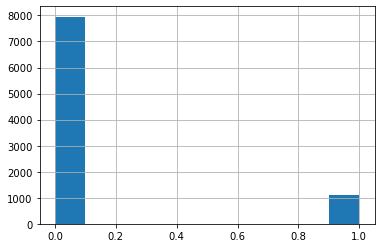

In [49]:
df['y_yes'].hist()

As it is not correctly balanced, let's splitt in a stratified way to be sure the same percentage of **no** and **yes** samples will be splitted to train and test

#### Splitting dataset into 75% train and 25% test

For use of the Pipeline to make sense, we will read the features again intead of using the scaled one from last step.

In [50]:
X_KBest_df = pd.read_csv('feature1.csv')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_KBest_df, y, test_size=0.25, random_state=R_SEED, stratify=y)

#check data
X_train

,balance,campaign,pdays,previous,last_contact,education_tertiary,housing_yes,contact_unknown,poutcome_success,poutcome_unknown
9028,36935,1,-1,0,-3,1,1,0,0,1
1694,276,1,-1,0,190,0,1,1,0,1
5535,1390,2,-1,0,-3,1,0,0,0,1
3549,-2,2,-1,0,99,1,0,0,0,1
1367,6,2,-1,0,130,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
5605,3529,2,-1,0,106,0,0,0,0,1
2445,825,2,-1,0,181,1,1,1,0,1
8722,347,6,-1,0,83,1,1,0,0,1
2625,507,1,300,2,184,0,1,0,1,0


In [52]:
best_models = [] # list to hold the best classifier

In [53]:
# Names of the various classification approaches for easy presentation of the results
names = ["Nearest Neighbors", "Decision Tree", "Naive Bayes", "Random Forest", "Ada BOOST", "XGBOOST"]

scores_1_try = [] #list variable to hold classification accuracy scores

current_best = { "classifier": None, "score": 0 } # hold the current step's best classifier

classifiers_1_try = [
    KNeighborsClassifier(3),  
    DecisionTreeClassifier(max_depth=5),    
    GaussianNB(),
    RandomForestClassifier(max_depth=5, max_features=1, n_estimators=1000),
    AdaBoostClassifier(learning_rate=0.1),
    XGBClassifier(use_label_encoder=False)]

for classifier in classifiers_1_try:
    pipeline = Pipeline(steps=[('scaler', RobustScaler()),('classifier', classifier)])
    cv = KFold(n_splits=3)
    pipeline.fit(X_train, y_train)
    n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv) 
    print(classifier)
    scores_1_try.append(mean(n_scores))
    if current_best["score"] < mean(n_scores):
        current_best = {"classifier": classifier, "score": mean(n_scores)}
    print('Model mean accuracy score: %.6f ' % mean(n_scores))
    print("\n -----------------------------------------------------------------------------------")

best_models.append(current_best) # add the current step best classifier to this list
#end of pipeline

KNeighborsClassifier(n_neighbors=3)
Model mean accuracy score: 0.865506 

 -----------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=5)
Model mean accuracy score: 0.888512 

 -----------------------------------------------------------------------------------
GaussianNB()
Model mean accuracy score: 0.842647 

 -----------------------------------------------------------------------------------
RandomForestClassifier(max_depth=5, max_features=1, n_estimators=1000)
Model mean accuracy score: 0.883941 

 -----------------------------------------------------------------------------------
AdaBoostClassifier(learning_rate=0.1)
Model mean accuracy score: 0.888807 

 -----------------------------------------------------------------------------------
[14:36:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from '

In [54]:
#Print data frame of prediction scores
scores_1_try_df = pd.DataFrame(zip(names,scores_1_try), columns=['Classifier', 'Accuracy Score'])

print(scores_1_try_df)

          Classifier  Accuracy Score
0  Nearest Neighbors        0.865506
1      Decision Tree        0.888512
2        Naive Bayes        0.842647
3      Random Forest        0.883941
4          Ada BOOST        0.888807
5            XGBOOST        0.889839


# 6 Classifier Model - The Second Try

In [55]:
# feature selection method with random forest as the estimator.
sel = SelectFromModel(RandomForestClassifier(n_estimators = 1000)).fit(X, y)
X_selected = sel.transform(X)
sel.get_support(indices=True)

array([ 0,  1,  2,  3,  5, 28])

In [56]:
# check the accuracy score
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=R_SEED)
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [57]:
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.88899


In [58]:
# get the columns selected information
sel.get_support(indices=True)

array([ 0,  1,  2,  3,  5, 28])

In [59]:
X_selected=X.iloc[:,sel.get_support(indices=True)]

X_selected.to_csv('feature2.csv', index=False)
X_selected.head()

,age,balance,campaign,pdays,last_contact,poutcome_success
0,40,580,1,-1,186,0
1,47,3644,2,-1,162,0
2,25,538,1,-1,212,0
3,42,1773,1,336,223,0
4,56,217,2,-1,120,0


#### There are 6 feature using random forest as an estimator

In [60]:
#Names of the various classification approaches for easy presentation of the results
names = ["Nearest Neighbors", "Decision Tree", "Naive Bayes", "Random Forest", "Ada BOOST", "XGBOOST"]

scores_2_try = [] #list variable to hold classification accuracy scores

current_best = { "classifier": None, "score": 0 } # hold the current step's best classifier
        
classifiers_2_try =  [
    KNeighborsClassifier(3),  
    DecisionTreeClassifier(max_depth=5),    
    GaussianNB(),
    RandomForestClassifier(max_depth=5, max_features=1, n_estimators=1000),
    AdaBoostClassifier(learning_rate=0.1),
    XGBClassifier(use_label_encoder=False)]

for classifier in classifiers_2_try:
    pipeline = Pipeline(steps=[('scaler', RobustScaler()),('classifier', classifier)])
    cv = KFold(n_splits=5)
    pipeline.fit(X_train, y_train)
    n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv)
    print(classifier)
    scores_2_try.append(mean(n_scores))
    if current_best["score"] < mean(n_scores):
        current_best = {"pipeline": pipeline, "score": mean(n_scores)}
    print('Model mean accuracy score: %.6f ' % mean(n_scores))
    #print(f1_score(pipeline.predict(X_train), y_train, average= None))# TODO: Debbug
    #print(classification_report(pipeline.predict(X_train), y_train)) #TODO: Debbug
    print("\n -----------------------------------------------------------------------------------")

best_models.append(current_best) # add the current step best classifier to this list
#end of pipeline

KNeighborsClassifier(n_neighbors=3)
Model mean accuracy score: 0.870522 

 -----------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=5)
Model mean accuracy score: 0.886892 

 -----------------------------------------------------------------------------------
GaussianNB()
Model mean accuracy score: 0.886890 

 -----------------------------------------------------------------------------------
RandomForestClassifier(max_depth=5, max_features=1, n_estimators=1000)
Model mean accuracy score: 0.887184 

 -----------------------------------------------------------------------------------
AdaBoostClassifier(learning_rate=0.1)
Model mean accuracy score: 0.887774 

 -----------------------------------------------------------------------------------
[14:37:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from '

In [61]:
#Print data frame of prediction scores
scores_2_try_df = pd.DataFrame(zip(names,scores_2_try), columns=['Classifier', 'Accuracy Score'])

print(scores_2_try_df)

          Classifier  Accuracy Score
0  Nearest Neighbors        0.870522
1      Decision Tree        0.886892
2        Naive Bayes        0.886890
3      Random Forest        0.887184
4          Ada BOOST        0.887774
5            XGBOOST        0.884974


# 7 Model Evaluation

## 7.1 Summing Up the scores of all models in each step. 

### Step 5 Classifiers

In [62]:
scores_1_try_df

,Classifier,Accuracy Score
0,Nearest Neighbors,0.865506
1,Decision Tree,0.888512
2,Naive Bayes,0.842647
3,Random Forest,0.883941
4,Ada BOOST,0.888807
5,XGBOOST,0.889839


### Step 6 Classifiers

In [63]:
scores_2_try_df

,Classifier,Accuracy Score
0,Nearest Neighbors,0.870522
1,Decision Tree,0.886892
2,Naive Bayes,0.886890
3,Random Forest,0.887184
4,Ada BOOST,0.887774
5,XGBOOST,0.884974


### Comparing Step 5 and 6 classifiers

In [64]:
print("The best Classifier in Step 5 is :")
scores_1_try_df.iloc[scores_1_try_df['Accuracy Score'].idxmax()]

The best Classifier in Step 5 is :


Classifier         XGBOOST
Accuracy Score    0.889839
Name: 5, dtype: object

In [65]:
print("The best Classifier in Step 6 is")
scores_2_try_df.iloc[scores_2_try_df['Accuracy Score'].idxmax()]

The best Classifier in Step 6 is


Classifier        Ada BOOST
Accuracy Score     0.887774
Name: 4, dtype: object

XGBoost was the Best model in Step 5 with accuracy of 0.889839 and Decision Tree was the best model in step 6
0.888365 of accuracy

In step 5 10 features were selected
In step 6 only 6 features were selected

You can see that best models from each step are different classifiers, and that the accuracy result of best model in step 6 was slightly less than better model in step 6 even with less number of features.


## 7.2 Confusion Matrix

In [66]:
model_step_6 = best_models[1]['pipeline'] # selecting the second that is the classifier of step 6

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

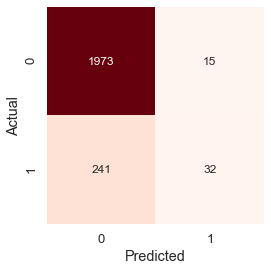

In [67]:
# Confusion Matrix

THRESHOLD = 0.5 # Threshhold choice here
y_pred = np.where(model_step_6.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
conf_matrix = confusion_matrix(y_test, y_pred)
#Generate seaborn heatmap for the confusion matrix

df_cm = pd.DataFrame(conf_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,4))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12}, cbar=False,
          vmax=conf_matrix.max(), square=True, fmt="d", cmap="Reds")

The result is telling us that we have 1969 + 42 correct predictions and 19 + 231 incorrect predictions.

## 7.3 Classification Report

To Understand better a binary classification models other then accuracy, is interesting to rely on  metrics like:

* **Recall Score**: The ratio of positives labeled by the model to all positives, TP / (TP + FN)
* **Precision Score**: The ratio of correctly labeled positives by the model to all positives, TP / (TP + FP)
* **F1 Score**: Harmonic mean o both  Recall and precision, 2 * (Recall * Precision)/ (Recall + Precision)
* **Support**: The number of occurrences of each class in y_test

This way let's plot the Classification report that tells us all of this metrics

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1988
           1       0.68      0.12      0.20       273

    accuracy                           0.89      2261
   macro avg       0.79      0.55      0.57      2261
weighted avg       0.87      0.89      0.85      2261



## 7.4 ROC Curve

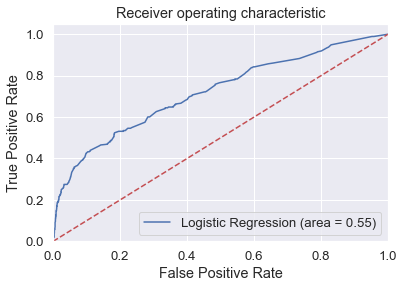

In [69]:
roc_auc = roc_auc_score(y_test, model_step_6.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_step_6.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

# TODO: ANSWER THE QUESTION BELOW

You should see that the number of false negative is quite big. It is easier for the classifier to determine the rejection (class 0), than to predict that the client will sign into the new banking product. Provide your insights on the possible cause or a way to improve our classifier performance.


# 8 Prediction


Creating new data dataframe as the Guidelines Suggest

In [70]:
new_data_df = pd.DataFrame({"age": [45, 65, 80,21], "balance": [8000, 700, 100, 300],"job":["blue-collar", "retired", "unknown", "students"], "marital": ["married", "divorced", "unknown", "single"], "housing": ["yes", "yes", "no", "no"], "contact": ["cellular", "telephone", "telephone", "cellular"], "campaign": [12, 2, 1 ,3], "pdays":[300, 1, 1, 90], "last_contact": [45, 1, 200, 180], "poutcome": ["success", "success", "unknown", "success"]})
new_data_df

,age,balance,job,marital,housing,contact,campaign,pdays,last_contact,poutcome
0,45,8000,blue-collar,married,yes,cellular,12,300,45,success
1,65,700,retired,divorced,yes,telephone,2,1,1,success
2,80,100,unknown,unknown,no,telephone,1,1,200,unknown
3,21,300,students,single,no,cellular,3,90,180,success


From this new data let's select the same columns we used in our step 6 feature selection that is stored in  feature2.csv

In [71]:
pd.read_csv('feature2.csv')

,age,balance,campaign,pdays,last_contact,poutcome_success
0,40,580,1,-1,186,0
1,47,3644,2,-1,162,0
2,25,538,1,-1,212,0
3,42,1773,1,336,223,0
4,56,217,2,-1,120,0
...,...,...,...,...,...,...
9037,26,689,1,-1,238,0
9038,47,1890,1,-1,133,0
9039,32,217,3,-1,187,0
9040,52,0,1,-1,176,0


Columns as used in step 6

In [72]:
columns = pd.read_csv('feature2.csv').columns # getting only columns of feature2.csv used in step 6

Transforming the only categorical remained in step 6 that is the poutcome

In [73]:
#Get dummy variables from catgeorical variables
poutcome = pd.get_dummies(new_data_df['poutcome'],prefix='poutcome')
new_data_df = new_data_df.join(poutcome)
new_data_df.drop('poutcome', axis=1, inplace=True)

#replacing any appearance of hypen ‘-‘
new_data_df = new_data_df.rename(columns=lambda x:x.replace('-','_'))

# filtering only the same columns as step 6
unseen_data = new_data_df[columns]

To Scale properly the unseed data we need to use the same scaler fit in train data of step 6
So we need to retrive the scaler from step 6 that was saved in best_model_step_6

In [74]:
#Use robust scaller to scale the feature selected
y_pred = np.where(model_step_6.predict_proba(unseen_data)[:,1] > 0.5, 'yes', 'no')#unseen_data_scaled

so The predictions are:

In [75]:
y_pred 

array(['no', 'yes', 'no', 'no'], dtype='<U3')

Concatenating the dataframe with the predictions we have:

In [76]:
new_data_df['y'] = y_pred
new_data_df

,age,balance,job,marital,housing,contact,campaign,pdays,last_contact,poutcome_success,poutcome_unknown,y
0,45,8000,blue-collar,married,yes,cellular,12,300,45,1,0,no
1,65,700,retired,divorced,yes,telephone,2,1,1,1,0,yes
2,80,100,unknown,unknown,no,telephone,1,1,200,0,1,no
3,21,300,students,single,no,cellular,3,90,180,1,0,no


## Additional Approach

In [77]:
for alpha in [0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.7, 0.9, 1 ]:
    pipeline = Pipeline(steps=[('scaler', RobustScaler()),('classifier', XGBClassifier(n_estimators = 1000, alpha=alpha, use_label_encoder=False))])
    pipeline.fit(X_train, y_train)
    print(classifier)
    scores_2_try.append(mean(n_scores))
    print('Model mean accuracy score: %.6f ' % mean(n_scores))
    print(f1_score(pipeline.predict(X_train), y_train, average= None))# TODO: Debbug
    print(classification_report(pipeline.predict(X_train), y_train)) #TODO: Debbug

    print("\n -----------------------------------------------------------------------------------")
    print(f1_score(pipeline.predict(X_test), y_test, average= None))# TODO: Debbug
    print(classification_report(pipeline.predict(X_test), y_test)) #TODO: Debbug                          


[14:37:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
Model mean accuracy score: 0.884974 
[0.99983233 0.99877601]
              precision    recall  f

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# setting the parameter grid
grid_parameters = {'kernel': ['linear', 'rbf'],'gamma': [1e-3, 1e-4],
                   'C': [1, 10, 50, 100]}

# perform hyperparameter tuning
print("# Tuning hyper-parameters for accuracy\n")

clf = GridSearchCV(SVC(random_state=42), grid_parameters, cv=5, 
          scoring='accuracy')
clf.fit(X_train, y_train)

# view accuracy scores for all the models
print("Grid scores for all the models based on CV:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
  print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))

# check out best model performance
print("\nBest parameters set found on development set:", clf.best_params_)
print("Best model validation accuracy:", clf.best_score_)

gs_best = clf.best_estimator_
tuned_y_pred = gs_best.predict(X_test)
print('\n\nTuned Model Stats:')
print(classification_report(y_test, tuned_y_pred, target_names=['class 0', 'class 1', 'class 2']))


# Tuning hyper-parameters for accuracy

